# Blog Post 2 - Auditing Bias

# Abstract

In this Blog post, we will conducted a bias audit on a Random Forest classification model for employment status, evaluating its fairness across racial. Using key fairness metrics such as calibration, error rate balance, and statistical parity, I analyzed whether the model produced consistent predictions across races. I implemented Chouldechova’s feasibility equation to assess the tradeoff between false positive and false negative rates, visualizing the results in a feasibility graph. Additionally, I examined disparities in employment outcomes across groups, highlighting potential systemic biases. The findings provide insight into how algorithmic predictions may reinforce existing inequalities, emphasizing the importance of fairness considerations in predictive modeling.

First, I will load in the data from the PUMS dataset for the state of Texas. This dataset has many, many feaures as you can see below.

In [7]:
from folktables import ACSDataSource, ACSEmployment, BasicProblem, adult_filter
import numpy as np

STATE = "TX"

data_source = ACSDataSource(survey_year='2018', 
                            horizon='1-Year', 
                            survey='person')

acs_data = data_source.get_data(states=[STATE], download=True)

acs_data.head()

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2018GQ0000026,7,1,5000,3,48,1013097,29,21,...,29,4,5,54,27,52,28,29,52,29
1,P,2018GQ0000057,7,1,6601,3,48,1013097,16,19,...,33,3,18,16,32,3,18,16,2,2
2,P,2018GQ0000070,7,1,4302,3,48,1013097,64,24,...,14,64,110,62,14,15,64,64,13,67
3,P,2018GQ0000079,7,1,700,3,48,1013097,260,20,...,57,451,261,272,59,477,261,258,480,56
4,P,2018GQ0000082,7,1,900,3,48,1013097,12,31,...,10,3,11,22,12,20,1,12,21,1


Here is a list of possible features that we can include in our model. These feautures include sex, race, age, and others. 

In [8]:
possible_features=['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR']
acs_data[possible_features].head()

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR
0,21,16.0,5,17,2,NaN,1,1.0,4.0,1,1,2,2,2.0,2,2,1.0
1,19,16.0,5,17,2,NaN,1,1.0,4.0,1,1,2,2,2.0,2,1,6.0
2,24,12.0,5,16,1,NaN,1,1.0,4.0,1,1,2,2,1.0,1,2,6.0
3,20,16.0,5,17,2,NaN,1,1.0,3.0,1,1,2,2,2.0,2,1,1.0
4,31,17.0,5,17,2,NaN,1,3.0,4.0,4,1,2,2,2.0,1,1,1.0


Because I am looking to predict employment, I will remove it from the features list. Similarly, I will remove race because that is what I am auditing.

In [9]:
features_to_use = [f for f in possible_features if f not in ["ESR", "RAC1P"]]

Here, I define that basic problem for this project. Key parameters in this `EmploymentProblem` are the feautres that I defined above are the target (employment) and the group (race). Additionally, `target_transform` maps all numbers that are not equal to 1 to 0. So now, we have a column of True/False values for this column. 

Now the employement column is a boolean and the race column is an integer column with the 9 cateogories of race defined in the dataset.

In [10]:
EmploymentProblem = BasicProblem(
    features=features_to_use,
    target='ESR',
    target_transform=lambda x: x == 1,
    group='RAC1P',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

features, label, group = EmploymentProblem.df_to_numpy(acs_data)

Now, we create our 80/20 train/test split on the data.

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

# Basic Questions

Let's put the training data features, group, and label into a single dataframe to make answering basic questions a little easier. 

In [12]:
import pandas as pd
df = pd.DataFrame(X_train, columns = features_to_use)
df["group"] = group_train
df["label"] = y_train
df

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,group,label
0,62.0,13.0,3.0,0.0,2.0,0.0,4.0,3.0,4.0,1.0,2.0,2.0,2.0,2.0,2.0,1,False
1,5.0,2.0,5.0,4.0,2.0,6.0,1.0,1.0,0.0,1.0,1.0,2.0,2.0,2.0,1.0,2,False
2,2.0,0.0,5.0,2.0,2.0,7.0,1.0,1.0,0.0,1.0,1.0,2.0,2.0,0.0,2.0,2,False
3,25.0,18.0,1.0,1.0,2.0,0.0,1.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,1.0,1,True
4,15.0,12.0,5.0,2.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,2.0,2.0,2.0,1.0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214475,42.0,22.0,1.0,1.0,2.0,0.0,1.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,2.0,1,True
214476,5.0,1.0,5.0,2.0,2.0,3.0,1.0,1.0,0.0,4.0,1.0,2.0,2.0,2.0,1.0,2,False
214477,56.0,16.0,5.0,2.0,2.0,0.0,1.0,1.0,4.0,2.0,1.0,2.0,2.0,2.0,1.0,3,True
214478,6.0,3.0,5.0,2.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,2.0,2.0,2.0,2.0,1,False


## 1. How many individuals are in the data?
To find the number of individual in the data, we can take a look at the number of rows.

In [52]:
df.shape[0]

214480

## 2. Of these individuals, what proportion have target label equal to 1? In employment prediction, these would correspond to employed individuals.

Because the employment vector is a column vector of booleans, the mean of that column will return the proportion of employed individuals in this dataset.

In [50]:
df["label"].mean()


np.float64(0.4513474449832152)

## 3. Of these individuals, how many are in each of the groups?

We can use the `value_counts()` method to get the number of people in each racial group.

In [49]:
df["group"].value_counts()


group
1    165969
2     20614
8     10544
6     10141
9      5803
3       836
5       401
7       158
4        14
Name: count, dtype: int64

## 4. In each group, what proportion of individuals have target label equal to 1?

We can use `groupby()` and `mean()` to get the proportions for each racial group.

In [ ]:
# Calculate the proportion of employed individuals in each racial group
df.groupby("group")["label"].mean()

group
1    0.455242
2    0.416756
3    0.431818
4    0.357143
5    0.461347
6    0.499359
7    0.430380
8    0.466711
9    0.353955
Name: label, dtype: float64

## 5. Intersectional Trends

We can take a look at the intersection of race and sex and how different combinations of the two effect employment. In this dataset 1 is male and 2 is female.

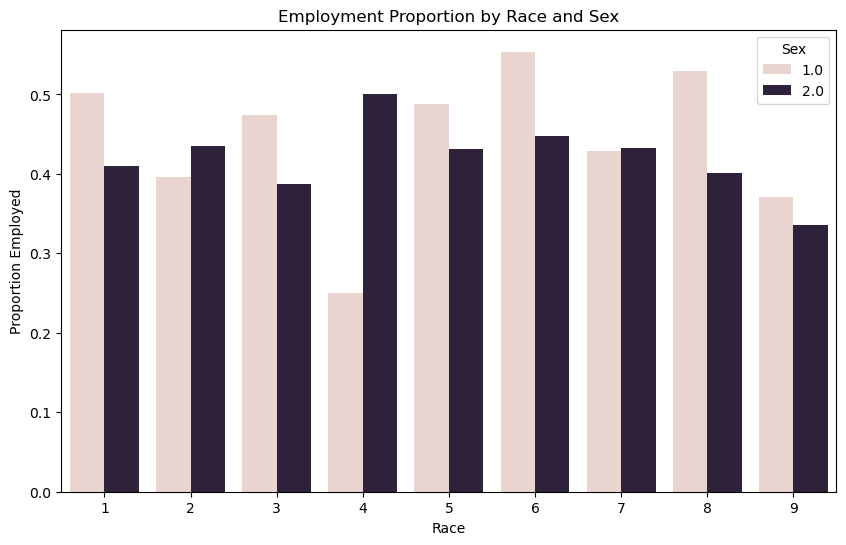

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
intersectional_df = df.groupby(["group", "SEX"])["label"].mean().reset_index()
sns.barplot(x="group", y="label", hue="SEX", data=intersectional_df)
plt.title("Employment Proportion by Race and Sex")
plt.xlabel("Race")
plt.ylabel("Proportion Employed")
plt.legend(title="Sex")
plt.show()


This bar chart displays the proportion of individuals employed across different racial groups, further broken down by sex. The two colors represent males (1.0) and females (2.0). Across most racial groups, there appears to be a consistent disparity in employment rates between males and females, with males generally having higher employment proportions than females. For example, in groups 4, 6, and 8, males show noticeably higher employment rates than females. However, in some cases, such as group 5, females have a higher employment rate than males. These disparities suggest that both race and sex impact employment outcomes, which could be an important factor to consider when evaluating fairness and bias in predictive models. Note that we are taking race out of our model as a feature, but this graph is interesting. 

Now that we've done some basic exploring of the data, we can start to build our model. I've decided to employ a RandomForest to try to predict employment status. To do this, I must tune the hyperparameter `max_depth`. In a Random Forest, tuning max_depth controls the maximum depth of each decision tree. The goal here is to try to balancing model complexity by preventing overfitting and underfitting with overly complex/simple trees.

I created a for loop that tries different max_depths on Random Forest models. It uses 5 fold cross validation to test each max_depth and takes the mean of these 5 scores to determine which value performs the best.

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

# Define a range of max_depth values to test
max_depth_values = [5, 10, 20, 30]  # Testing different depths


best_score = 0  # Initialize best score
best_depth = None  # Initialize best depth

# Loop through different max_depth values
for depth in max_depth_values:
    print(f"Training Random Forest with max_depth={depth}")

    # Initialize Random Forest with current max_depth
    RF = RandomForestClassifier(max_depth=depth, random_state=7)

    # Perform cross-validation (5-fold)
    scores = cross_val_score(RF, X_train, y_train, cv=5)

    # Compute mean accuracy
    mean_score = np.mean(scores)
    print(f"Mean CV Accuracy: {mean_score:.4f}\n")

    # Track the best performing max_depth
    if mean_score > best_score:
        best_score = mean_score
        best_depth = depth

# Print best depth and score
print(f"Best max_depth: {best_depth} with accuracy: {best_score:.4f}")


Training Random Forest with max_depth=5
Mean CV Accuracy: 0.8168

Training Random Forest with max_depth=10
Mean CV Accuracy: 0.8252

Training Random Forest with max_depth=20
Mean CV Accuracy: 0.8252

Training Random Forest with max_depth=30
Mean CV Accuracy: 0.8066

Best max_depth: 20 with accuracy: 0.8252


Based on the cross-validation results, max_depth = 20 is the optimal choice for the Random Forest model. At this depth, the model achieved the highest mean CV accuracy of 0.8252, indicating that it balances predictive power and generalization. While max_depth = 10 produced the same accuracy, deeper trees (max_depth = 30 and beyond) led to a decline in accuracy, suggesting potential overfitting.

Using max_depth = 20 ensures that the model captures important patterns in the data without becoming too complex. This depth allows the model to generalize well to unseen data while maintaining strong performance. The final model will now be trained using this optimized hyperparameter and evaluated on the test set.

Here, I define and fit my Random Forest model. We can also extract the model predictions and store them in `y_hat`.

In [15]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(max_depth=20, random_state=7)
RF.fit(X_train, y_train)
y_hat = RF.predict(X_test)


# Overall Measures

In this section, I will audit this Random Forest model for racial bias.

First, I defined a function that takes in the actual and predicted values for employment and calculates some important information about them. This function takes in the actual and predicted values and returns the accuracy, PPV (Positive Predictive Value), FNR (False Negative Rate), and FPR (False Positive Rate) in a dictionary. 

In [16]:
from sklearn.metrics import confusion_matrix
# Define function to compute metrics manually without using .ravel()
def compute_metrics(y_true, y_pred):
    C = confusion_matrix(y_true, y_pred)

    # Extract confusion matrix values manually
    tn = C[0, 0] 
    fp = C[0, 1] 
    fn = C[1, 0] 
    tp = C[1, 1] 

    # Compute metrics
    accuracy = (y_pred == y_true).mean()
    ppv = tp / (tp + fp) 
    fnr = fn / (fn + tp) 
    fpr = fp / (fp + tn)

    return pd.Series({"Accuracy": accuracy, "PPV": ppv, "FNR": fnr, "FPR": fpr})

Now to take a look at the overall model preformance (without considering it by race) we get the following values for Accuracy, PPV, FNR, and FPR. 

In [17]:
compute_metrics(y_test, y_hat)

Accuracy    0.824562
PPV         0.777926
FNR         0.139930
FPR         0.205100
dtype: float64

Now we can take a look at how these values look for each of the 9 race categories using the same function. Here, I create a pandas dataframe with the test employment values (`y_test`), my model's predictions (`y_hat`), and the race (`group`). Then I use group by and lambda to apply the function by race.

In [19]:
import pandas as pd
from sklearn.metrics import confusion_matrix

# Create DataFrame with predictions and actual values
df_results = pd.DataFrame({"y_test": y_test, "y_hat": y_hat, "group": group_test})

# Apply function to each subgroup
results_df = df_results.groupby("group").apply(lambda g: compute_metrics(g["y_test"], g["y_hat"]))
results_df

/var/folders/3p/_jcm4hhd7rj59x0q1n5_8yrw0000gn/T/ipykernel_2353/3277346927.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results_df = df_results.groupby("group").apply(lambda g: compute_metrics(g["y_test"], g["y_hat"]))


,Accuracy,PPV,FNR,FPR
group,,,,
1,0.824672,0.780110,0.140630,0.204641
2,0.829062,0.763998,0.139252,0.194065
3,0.802956,0.737864,0.146067,0.236842
4,0.833333,0.750000,0.000000,0.333333
5,0.807339,0.800000,0.185185,0.200000
6,0.803520,0.767733,0.116800,0.279966
7,0.851852,0.846154,0.153846,0.142857
8,0.815729,0.779201,0.151764,0.213091
9,0.861247,0.782609,0.139579,0.138274


Now I am preforming a check to see if my model is calibrated with respect to race. This chunk calculates the actual employment rate (from y_test) for each group, but only for cases where the model predicted employment (y_hat == 1). By grouping by "group" and taking the mean of y_test, it measures how often a positive prediction (y_hat = 1) was actually correct within each racial group. This helps determine if the model's positive predictions are equally reliable across different demographic groups.

In [14]:
# Compute actual employment rate when model predicts 1, by racial group
calibration_check = df_results[df_results["y_hat"] == 1].groupby("group")["y_test"].mean()
calibration_check

group
1    0.780110
2    0.763998
3    0.737864
4    0.750000
5    0.800000
6    0.767733
7    0.846154
8    0.779201
9    0.782609
Name: y_test, dtype: float64

Based on these results, I conclude that this model is generally well calibrated. The check shows that the actual employment rates for individuals predicted as employed are fairly consistent across groups, ranging from approximately 0.737 to 0.846. No single group has an extreme deviation from the others, meaning that when the model predicts someone is employed, the likelihood of them actually being employed is fairly stable across racial groups. While perfect calibration would require these values to be exactly equal, this level of consistency suggests that the model does not exhibit significant calibration bias. If we wanted to be extra thorough, we could do a statistical test to see if these variations are significant or just random chance.

Now, I want to check if my model satisifies error rate balance. We can look at the dataframe from earlier to gauge if it satisfies error rate balance. 

In [20]:
results_df

,Accuracy,PPV,FNR,FPR
group,,,,
1,0.824672,0.780110,0.140630,0.204641
2,0.829062,0.763998,0.139252,0.194065
3,0.802956,0.737864,0.146067,0.236842
4,0.833333,0.750000,0.000000,0.333333
5,0.807339,0.800000,0.185185,0.200000
6,0.803520,0.767733,0.116800,0.279966
7,0.851852,0.846154,0.153846,0.142857
8,0.815729,0.779201,0.151764,0.213091
9,0.861247,0.782609,0.139579,0.138274


From the table we can see that my model does not fully satisfy error rate balance across racial groups, as defined by Chouldechova. Error rate balance requires that FPR and FNR be approximately equal across all groups. I'd say that there is significant variation in both FNR and FPR across groups like FPR ranges from 0.138 to 0.333 and FNR ranges between 0.000 and 0.185. This indicates that some groups are disproportionately classified as false positives or false negatives.

Finally, I can check for statistical parity in my model. The code calculates the proportion of individuals predicted as employed (y_hat = 1) within each group by grouping the dataset by "group" and computing the mean of the predicted values. This provides insight into whether the model's predictions are distributed equally across different groups, which is used to assess statistical parity.

In [25]:
# Compute the proportion of individuals predicted as employed (y_hat == 1) per group
statistical_parity_check = df_results.groupby("group")["y_hat"].mean()
statistical_parity_check

group
1    0.504468
2    0.475355
3    0.507389
4    0.666667
5    0.504587
6    0.588621
7    0.481481
8    0.511565
9    0.402943
Name: y_hat, dtype: float64

Statistical parity requires that the proportion of individuals predicted as employed is approximately equal across all groups. Based on the output, the predicted employment rates range from 0.4029 (Group 9) to 0.6667 (Group 4), with noticeable variation across groups. Some groups have significantly higher predicted employment rates than others, particularly Group 4 (0.6667) compared to Group 9 (0.4029). Since these differences are quite substantial, the model does not strictly satisfy statistical parity, as predictions are not evenly distributed among groups. However, whether this deviation is acceptable depends on the fairness criteria being applied.

# Feasible FNR and FPR Rates



### Equation 2.6

$$
\text{FPR} = \frac{p}{1 - p} \cdot \frac{1 - \text{PPV}}{\text{PPV}} \cdot (1 - \text{FNR})
$$


-FPR (False Positive Rate) is the probability that an actual negative instance is incorrectly classified as positive.
-p (Prevalence) is rhe proportion of actual positive instances in the dataset.
-PPV (Positive Predictive Value) is the probability that a predicted positive instance is actually positive.
-FNR (False Negative Rate) is the probability that an actual positive instance is incorrectly classified as negative.

The below chunk calculates the feasible false positive rate (FPR) for each group using Equation 2.6 by incorporating the prevalence into the calculations. First, it computes the prevalence for each group by averaging the true labels (y_test) and merges this information into a dataframe. Then, using the given equation, it derives the Feasible FPR, which represents the expected false positive rate based on the observed prevalence, positive predictive value, and false negative rate. The updated dataframe displays the calculated feasible FPR alongside the actual FPR, allowing for a comparison of observed vs. theoretically feasible error rates across groups.

In [21]:
import pandas as pd

# Assuming results_df already contains 'group', 'PPV', 'FNR', and 'FPR'
# Compute prevalence (p) for each group using y_test from df_results (individual-level data)
prevalence = df_results.groupby("group")["y_test"].mean().reset_index()
prevalence.columns = ["group", "Prevalence"]

# Merge prevalence into results_df
results_df = results_df.merge(prevalence, on="group", how="left")

# Compute Feasible FPR using Equation (2.6)
results_df["Feasible_FPR"] = (results_df["Prevalence"] / (1 - results_df["Prevalence"])) * \
                             ((1 - results_df["PPV"]) / results_df["PPV"]) * \
                             (1 - results_df["FNR"])

results_df

,group,Accuracy,PPV,FNR,FPR,Prevalence,Feasible_FPR
0,1,0.824672,0.780110,0.140630,0.204641,0.457941,0.204641
1,2,0.829062,0.763998,0.139252,0.194065,0.421924,0.194065
2,3,0.802956,0.737864,0.146067,0.236842,0.438424,0.236842
3,4,0.833333,0.750000,0.000000,0.333333,0.500000,0.333333
4,5,0.807339,0.800000,0.185185,0.200000,0.495413,0.200000
5,6,0.803520,0.767733,0.116800,0.279966,0.511666,0.279966
6,7,0.851852,0.846154,0.153846,0.142857,0.481481,0.142857
7,8,0.815729,0.779201,0.151764,0.213091,0.469931,0.213091
8,9,0.861247,0.782609,0.139579,0.138274,0.366503,0.138274


Now we can generate a graph to view the Feasible (FNR, FPR) Combinations graph. This is inspired by Chouldechova’s figure 5 from the reading. It plots the observed false negative rates (FNR) and false positive rates (FPR) for each group alongside the theoretically feasible FNR-FPR tradeoff lines derived from Equation 2.6. The tradeoff lines are calculated using the prevalence-adjusted feasible FPR values, showing the relationship between error rates across groups. Each group is assigned a unique color, ensuring that the observed points match their respective feasible tradeoff lines. This visualization helps assess how well the observed FNR-FPR values align with the theoretically achievable fairness constraints.

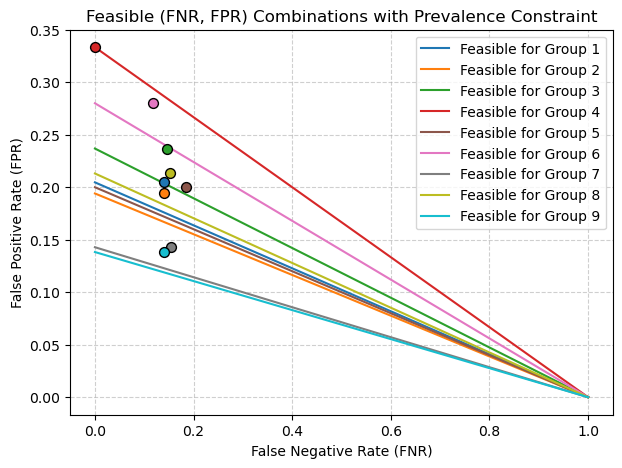

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Extract observed values from results_df
groups = results_df["group"]
FNR = results_df["FNR"]
FPR = results_df["FPR"]
Feasible_FPR = results_df["Feasible_FPR"]  # Precomputed from the equation

# Define colors for each group
colors = plt.cm.tab10(np.linspace(0, 1, len(groups)))  # Using tab10 colormap

# Generate feasible FNR-FPR tradeoff line using equation
fnr_range = np.linspace(0, 1, 100)

# Compute target FPR (equalizing across all groups)
target_fpr = np.mean(FPR)

# Define prevalence (p) and positive predictive value (PPV) - Assumed fixed
p = 0.5  # Example prevalence
ppv = 0.6  # Example PPV

# Compute required FNR adjustments using Equation (2.6)
Required_FNR_Adjustment = 1 - (target_fpr * (1 - p) * ppv) / (p * (1 - ppv)) - FNR

# Store adjustments back into results_df
results_df["Required_FNR_Adjustment"] = Required_FNR_Adjustment

# Create figure
plt.figure(figsize=(7, 5))

# Plot feasible tradeoff lines and corresponding observed points
for i, group in enumerate(groups):
    color = colors[i]  # Assign color to group
    plt.plot(fnr_range, Feasible_FPR[i] * (1 - fnr_range), color=color, label=f"Feasible for Group {group}")
    plt.scatter(FNR[i], FPR[i], color=color, edgecolors="black", s=50, zorder=3)  # Matching color with a black outline

# Labels and styling
plt.xlabel("False Negative Rate (FNR)")
plt.ylabel("False Positive Rate (FPR)")
plt.title("Feasible (FNR, FPR) Combinations with Prevalence Constraint")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# Show plot
plt.show()



In [27]:
results_df["Required_FNR_Adjustment"]

0    0.535525
1    0.536903
2    0.530087
3    0.676155
4    0.490970
5    0.559355
6    0.522309
7    0.524391
8    0.536576
Name: Required_FNR_Adjustment, dtype: float64

The analysis of feasible false negative rates (FNR) and false positive rates (FPR) using equation (2.6) provides insights into how fair the model could be across groups. The generated plot compares the observed FNR-FPR values against theoretically feasible values, given fixed prevalence and positive predictive value (PPV). While the observed points generally align with the feasible trade-offs, some groups exhibit deviations, indicating disparities in error rates. To enforce fairness by equalizing FPR across groups, the model's decision thresholds would need adjustment, which, according to equation (2.6), would require modifying the FNR distribution. This trade-off highlights the challenge of simultaneously achieving error rate balance while maintaining predictive performance. Overall, while the model operates within a reasonable range of feasible FNR-FPR values, further refinements may be necessary to ensure parity across groups, depending on the fairness criteria prioritized.

If we take a look at the `Required_FNR_Adjustment` values across groups, we can see that if we acheive equalty there needs to be modification to the FNR. Some groups require relatively small adjustments (ex: ~0.49), while others demand more significant shifts (ex: ~0.67), further highlighting disparities in the model’s treatment of different groups. Most notably, Group 4 exhibits the highest required FNR adjustment, indicating that its current false negative rate is substantially lower than what would be needed for equalized FPR. On the other side, Group 5 requires the least modification (0.490), suggesting it is already closer to the equalized threshold. These discrepancies show that it is difficult to balance fairness and preserve model performance at the same time. Reducing FPR differences across groups will affect the trade-off between false positives and false negatives. 

# Conclusion

A model that predicts employment status could benefit job seekers by providing insights into hiring patterns and helping them optimize their applications. A company like a recruitingment agency could use this model to help its client get insights into how to atain jobs easier. Another example is a firm that is looking to expand and leverage the model to assess candidate pools more efficiently. This is very prevalent right now with in many industries. A final example could be a bank assesing whether or not to give someone a loan. They could predict employement and either give or deny someone a loan. 

Deploying this model on a large scale could have significant societal implications, particularly due to disparities in false positive rates (FPR) and false negative rates (FNR) across groups. Some groups in the dataset exhibit higher FNRs, meaning they are more likely to be incorrectly classified as unemployed when they are actually employed, which could unfairly limit opportunities for individuals in those groups. Similarly, groups with higher FPRs may be incorrectly classified as employed when they are not, potentially leading to misallocation of resources or hiring biases. These inconsistencies could reinforce existing disparities in employment and financial decision-making if the model is used without bias mitigation strategies.

I've concluded that the model appears to be well-calibrated but does not satisfy error rate balance across groups. The observed disparities in false positive and false negative rates suggest that some racial groups are more likely to be incorrectly classified as employed or unemployed. This type of bias could have severe consequences as mentioned above.

Beyond bias, another conern that I have for this algoritm is data privacy. If used in hiring or financial decisions, the model might become a black box that unfairly determines people's opportunities without transparency. That is why it is importing to complete bias audits for all ML systems. Additionally, there could be bias baked into the actual data itself, not just the algorithm. If the data itself is biased, this could create a negative feedback group that affects marginalized groups in an unfair manner. 
